<a href="https://colab.research.google.com/github/hbeychaner/Digit-Classification/blob/master/Digit_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# Make sure libraries for the project are installed and imported
!pip install librosa
import librosa
import matplotlib.pyplot as plt 
import os
import pylab
import numpy as np 
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import librosa.display
import cv2
import random
from glob import glob
import pandas as pd
from sklearn.model_selection import train_test_split


# Clone the GitHub repo to the local environment
!git clone https://github.com/Jakobovski/free-spoken-digit-dataset.git

Cloning into 'free-spoken-digit-dataset'...
remote: Enumerating objects: 559, done.
remote: Counting objects: 100% (559/559), done.
remote: Compressing objects: 100% (539/539), done.
remote: Total 3157 (delta 22), reused 555 (delta 20), pack-reused 2598
Receiving objects: 100% (3157/3157), 23.92 MiB | 32.01 MiB/s, done.
Resolving deltas: 100% (65/65), done.


In [3]:
# Load an audio file to see the shape. SR = Sampling rate, WAV shape = length. 
wav, sr = librosa.load('free-spoken-digit-dataset/recordings/0_jackson_0.wav', sr=None)
print ('Sampling Rate:', sr)
print ('WAV shape:', wav.shape)

Sampling Rate: 8000
WAV shape: (5148,)


In [4]:
# Calculate the length of the WAV file in S
length = wav.shape[0]/sr
print('length:', length, 'secs')

length: 0.6435 secs


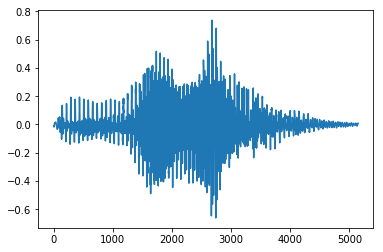

In [5]:
# Plot the waveform for fun
plt.plot(wav)

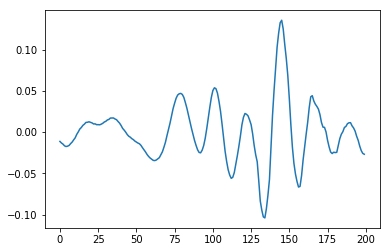

In [6]:
# Let's look at this file a little more closely, to understand how waveforms look close-up.
plt.plot(wav[0:200])

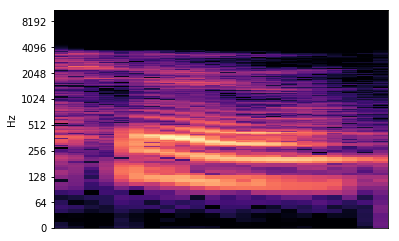

In [16]:
# We need to convert each wave file into a spectrogram so the neural network can
# extrapolate patterns. Sound pressure information is insufficient for this type
# of classification, but spectrograms give a visual representation that CNNs 
# are better at analysing.

D = librosa.amplitude_to_db(np.abs(librosa.stft(wav)), ref=np.max)
librosa.display.specshow(D, y_axis='log')

In [14]:
# Make a folder to store our spectrogram images.
!mkdir spectrograms

# Now create a list of labels for the training data and convert it to a 
# numpy array for use with neural network. 
y = []


pad = lambda a, i: a[0: i] if a.shape[0] > i else np.hstack((a, np.zeros(i - a.shape[0])))

# Convert all WAVs to spectrograms, save the images to our new folder
for fname in os.listdir('free-spoken-digit-dataset/recordings'):
  
  # Load the WAV
  wav, sr = librosa.load('free-spoken-digit-dataset/recordings/' + fname)
  
  # Pad the wav files so they're of uniform length
  padded = pad(wav, 30000)
  save_path = 'spectrograms/' + fname + '.jpg'

  # No axis
  pylab.axis('off')
  
  # Remove the white edge
  pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[]) 
  
  # Save the image
  S = librosa.feature.melspectrogram(y=wav, sr=sr)
  librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
  pylab.savefig(save_path, bbox_inches=None, pad_inches=0)
  pylab.close()


mkdir: cannot create directory ‘spectrograms’: File exists


In [0]:
# Now initiate a neural network to classify all the images and label them 
# accordingly
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

In [18]:
# Make a training set and a label set, keep them separate. 
from sklearn.model_selection import train_test_split
!pip install split_folders
import split_folders


In [0]:
# ../input/
PATH = os.path.abspath(os.path.join('..', 'content'))

# ../input/sample/images/
SOURCE_IMAGES = os.path.join(PATH, "spectrograms")

# ../input/sample/images/*.png
images = glob(os.path.join(SOURCE_IMAGES, "*.jpg"))

In [0]:
def proc_images():
    #Returns array:
    #    x is an array of resized images

    x = [] # images as arrays
    y = [] # array of labels
    WIDTH = 216 # these are scaled to 1/2 orginial size, aspect ratio maintained 
    HEIGHT = 144

    for img in images:
        base = os.path.basename(img)
        
        # Append labels to a list (y) 
        struct = base.split('_')
        digit = struct[0]
        y.append(digit)
        
        # Read and resize image
        full_size_image = cv2.imread(img)
        x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))

    return x,y

In [0]:
# And finally, the loaded, downsized images along with their labels 
x,y = proc_images()

In [0]:
# Make the train/test split.
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [0]:
# Initiate a classifier.
classifier = Sequential()

# Convolution layer
classifier.add(Convolution2D(32, (5, 5), input_shape=(144, 216, 3), activation = 'relu'))

# Pooling layer
classifier.add(MaxPooling2D(pool_size=(2,2)))

# Flattening layer
classifier.add(Flatten())

In [0]:
# Full connection of CNN, just two layers
classifier.add(Dense(units=128, activation='relu'))
classifier.add(Dense(units=10, activation='sigmoid'))

# Compile CNN
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
# Convert labels to one-hot encoding because it's a multi-class problem
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [122]:
# Train model
adam = tf.train.AdamOptimizer()
classifier.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['top_k_categorical_accuracy'])
print(classifier.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 140, 212, 32)      2432      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 70, 106, 32)       0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 237440)            0         
_________________________________________________________________
dense_25 (Dense)             (None, 128)               30392448  
_________________________________________________________________
dense_26 (Dense)             (None, 10)                1290      
Total params: 30,396,170
Trainable params: 30,396,170
Non-trainable params: 0
_________________________________________________________________
None


In [124]:
# Evaluate model on training data
classifier.fit(x = np.array(X_train), y = np.array(y_train), validation_split=0.1, verbose=2, epochs=5)

# Evaluate model on unseen data
score = classifier.evaluate(np.array(X_test), np.array(y_test), verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

Train on 1206 samples, validate on 134 samples
Epoch 1/5
 - 65s - loss: 7.1612 - top_k_categorical_accuracy: 0.6252 - val_loss: 7.8858 - val_top_k_categorical_accuracy: 0.5746
Epoch 2/5
 - 66s - loss: 7.1612 - top_k_categorical_accuracy: 0.6252 - val_loss: 7.8858 - val_top_k_categorical_accuracy: 0.5746
Epoch 3/5
 - 66s - loss: 7.1612 - top_k_categorical_accuracy: 0.6252 - val_loss: 7.8858 - val_top_k_categorical_accuracy: 0.5746
Epoch 4/5
 - 65s - loss: 7.1612 - top_k_categorical_accuracy: 0.6252 - val_loss: 7.8858 - val_top_k_categorical_accuracy: 0.5746
Epoch 5/5
 - 66s - loss: 7.1612 - top_k_categorical_accuracy: 0.6252 - val_loss: 7.8858 - val_top_k_categorical_accuracy: 0.5746
Test accuarcy: 55.91%


In [114]:
np.array(y_train).shape

(1340, 10)